In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import datetime
import itertools
from shapely.geometry import Point, LineString
from geopy.distance import great_circle, geodesic

In [12]:
cities = gpd.read_file('./data/us-major-cities/USA_Major_Cities.shp')
og_crs = cities.crs
cities

,FID,NAME,CLASS,ST,STFIPS,PLACEFIPS,CAPITAL,POP_CLASS,POPULATION,POP2010,...,MARHH_NO_C,MHH_CHILD,FHH_CHILD,FAMILIES,AVE_FAM_SZ,HSE_UNITS,VACANT,OWNER_OCC,RENTER_OCC,geometry
0,1,Ammon,city,ID,16,1601990,None,6,15181,13816,...,1131,106,335,3352,3.61,4747,271,3205,1271,POINT (-111.95410 43.47579)
1,2,Blackfoot,city,ID,16,1607840,None,6,11946,11899,...,1081,174,381,2958,3.31,4547,318,2788,1441,POINT (-112.34557 43.19394)
2,3,Boise City,city,ID,16,1608830,State,8,225405,205671,...,21233,2414,5919,50647,2.97,92700,6996,52345,33359,POINT (-116.23011 43.59901)
3,4,Burley,city,ID,16,1611260,None,6,10727,10345,...,861,139,358,2499,3.37,3885,241,2183,1461,POINT (-113.79329 42.53674)
4,5,Caldwell,city,ID,16,1612250,None,7,53942,46237,...,3113,686,1755,10776,3.51,16323,1428,9699,5196,POINT (-116.68562 43.66163)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3881,3882,Herndon,town,VA,51,5136648,None,6,23993,23292,...,1848,306,525,5357,3.46,7813,341,4558,2914,POINT (-77.38672 38.96993)
3882,3883,Highland Springs,Census Designated Place,VA,51,5137032,None,6,16618,15711,...,1187,206,1323,4157,3.03,6621,513,3795,2313,POINT (-77.32854 37.55172)
3883,3884,Hollins,Census Designated Place,VA,51,5137880,None,6,15033,14673,...,1806,115,413,3800,2.87,6435,385,4361,1689,POINT (-79.95348 37.34338)
3884,3885,Hopewell,city,VA,51,5138424,None,6,22935,22591,...,1963,305,1465,5877,3.00,10121,992,4906,4223,POINT (-77.29837 37.29038)


In [13]:
cols_of_interest = [
    'NAME', # name of city
    'CLASS', # city, town, etc
    'ST', # state code
    # 'PLACEFIPS',
    # 'CAPITAL',
    # 'POP_CLASS',
    'POPULATION',
    'geometry' # Point
]
cities = cities[cols_of_interest]
# drop AK and HI
cities = cities[(cities['ST'] != 'AK') & (cities['ST'] != 'HI')]
cities

,NAME,CLASS,ST,POPULATION,geometry
0,Ammon,city,ID,15181,POINT (-111.95410 43.47579)
1,Blackfoot,city,ID,11946,POINT (-112.34557 43.19394)
2,Boise City,city,ID,225405,POINT (-116.23011 43.59901)
3,Burley,city,ID,10727,POINT (-113.79329 42.53674)
4,Caldwell,city,ID,53942,POINT (-116.68562 43.66163)
...,...,...,...,...,...
3881,Herndon,town,VA,23993,POINT (-77.38672 38.96993)
3882,Highland Springs,Census Designated Place,VA,16618,POINT (-77.32854 37.55172)
3883,Hollins,Census Designated Place,VA,15033,POINT (-79.95348 37.34338)
3884,Hopewell,city,VA,22935,POINT (-77.29837 37.29038)


<Axes: >

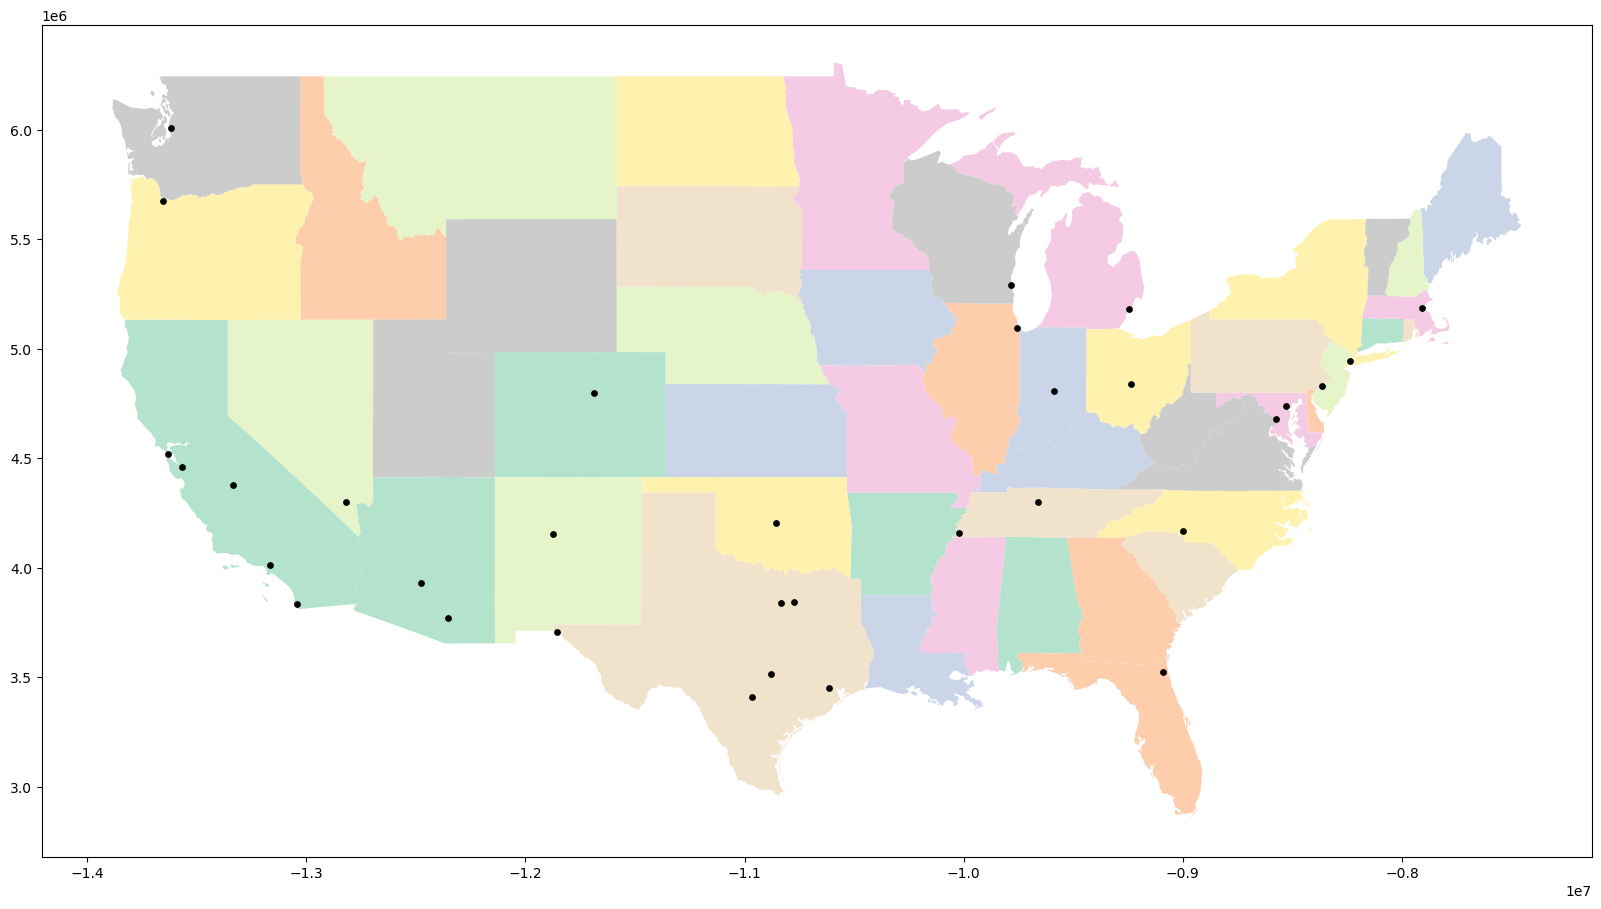

In [14]:
big_cities: gpd.GeoDataFrame = cities[cities['POPULATION'] > 500e3]

states = gpd.read_file('data/us-states/States_shapefile.shp').to_crs(epsg=3395)
# remove AK and HI
states: gpd.GeoDataFrame = states[(states['State_Code'] != 'AK') & (states['State_Code'] != 'HI')] # type: ignore

cities_for_plot: gpd.GeoDataFrame = gpd.GeoDataFrame(big_cities).to_crs(epsg=3395) # type: ignore
cities_for_plot.plot(ax=states.plot(cmap='Pastel2', figsize=(20,20)), marker='o', color='black', markersize=15)


In [15]:
# returns the geopy great_circle between two shapely Points (note reversal of x<->y)
def great_circle_two_points(pt1: Point, pt2: Point):
    return great_circle((pt1.y, pt1.x), (pt2.y, pt2.x))

big_cities_cross = big_cities.merge(big_cities, how='cross', suffixes=('_dep', '_arr'))
idx = big_cities_cross['NAME_dep'] != big_cities_cross['NAME_arr']
big_cities_cross = big_cities_cross[idx]
big_cities_cross = big_cities_cross.reset_index().drop(columns='index')

# assume annual passenger volume (in each direction) is 2.5% of the combined population of the two cities
passenger_vol = 0.025 * (big_cities_cross['POPULATION_dep'] + big_cities_cross['POPULATION_arr'])
big_cities_cross['annual_passengers'] = passenger_vol
# todo: this is a rudimentary way of removing duped pairs: (drop rows that have exact same passenger vol)
big_cities_cross = big_cities_cross[~passenger_vol.duplicated()]
# intercity distances
big_cities_cross['distance_km'] = big_cities_cross.apply(
    lambda row: great_circle_two_points(row['geometry_dep'], row['geometry_arr']).km,
    axis='columns'
)

big_cities_cross

,NAME_dep,CLASS_dep,ST_dep,POPULATION_dep,geometry_dep,NAME_arr,CLASS_arr,ST_arr,POPULATION_arr,geometry_arr,annual_passengers,distance_km
0,Chicago,city,IL,2781116,POINT (-87.64715 41.75649),Indianapolis,city,IN,864712,POINT (-86.14634 39.77710),91145.700,253.796625
1,Chicago,city,IL,2781116,POINT (-87.64715 41.75649),Los Angeles,city,CA,3986442,POINT (-118.27058 34.05279),169188.950,2802.884604
2,Chicago,city,IL,2781116,POINT (-87.64715 41.75649),San Diego,city,CA,1397856,POINT (-117.14556 32.72033),104474.300,2781.018748
3,Chicago,city,IL,2781116,POINT (-87.64715 41.75649),San Francisco,city,CA,871042,POINT (-122.44245 37.76692),91303.950,2986.391037
4,Chicago,city,IL,2781116,POINT (-87.64715 41.75649),San Jose,city,CA,1042940,POINT (-121.88641 37.33941),95601.400,2956.524204
...,...,...,...,...,...,...,...,...,...,...,...,...
958,El Paso,city,TX,693738,POINT (-106.48718 31.75760),Houston,city,TX,2333285,POINT (-95.36751 29.75876),75675.575,1084.985712
959,El Paso,city,TX,693738,POINT (-106.48718 31.75760),San Antonio,city,TX,1442472,POINT (-98.49250 29.42354),53405.250,807.805847
990,Fort Worth,city,TX,851362,POINT (-97.31305 32.74683),Houston,city,TX,2333285,POINT (-95.36751 29.75876),79616.175,380.239509
991,Fort Worth,city,TX,851362,POINT (-97.31305 32.74683),San Antonio,city,TX,1442472,POINT (-98.49250 29.42354),57345.850,386.215969


In [16]:
# High speed double track on new stone rail road stone bed -- high cost/km = 1650000
# Install a Centralized traffic control system double track -- high cost/km = 257825
# source: https://compassinternational.net/railroad-engineering-construction-cost-benchmarks/
cost_per_km = 1650000 + 257825
big_cities_cross['construction_cost_usd'] = big_cities_cross['distance_km'] * cost_per_km

# assume average HSR travel speed of 200 km/h
hsr_avg_speed = 200
big_cities_cross['hsr_travel_time_hr'] = big_cities_cross['distance_km'] / hsr_avg_speed

big_cities_cross

,NAME_dep,CLASS_dep,ST_dep,POPULATION_dep,geometry_dep,NAME_arr,CLASS_arr,ST_arr,POPULATION_arr,geometry_arr,annual_passengers,distance_km,construction_cost_usd,hsr_travel_time_hr
0,Chicago,city,IL,2781116,POINT (-87.64715 41.75649),Indianapolis,city,IN,864712,POINT (-86.14634 39.77710),91145.700,253.796625,4.841995e+08,1.268983
1,Chicago,city,IL,2781116,POINT (-87.64715 41.75649),Los Angeles,city,CA,3986442,POINT (-118.27058 34.05279),169188.950,2802.884604,5.347413e+09,14.014423
2,Chicago,city,IL,2781116,POINT (-87.64715 41.75649),San Diego,city,CA,1397856,POINT (-117.14556 32.72033),104474.300,2781.018748,5.305697e+09,13.905094
3,Chicago,city,IL,2781116,POINT (-87.64715 41.75649),San Francisco,city,CA,871042,POINT (-122.44245 37.76692),91303.950,2986.391037,5.697511e+09,14.931955
4,Chicago,city,IL,2781116,POINT (-87.64715 41.75649),San Jose,city,CA,1042940,POINT (-121.88641 37.33941),95601.400,2956.524204,5.640531e+09,14.782621
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
958,El Paso,city,TX,693738,POINT (-106.48718 31.75760),Houston,city,TX,2333285,POINT (-95.36751 29.75876),75675.575,1084.985712,2.069963e+09,5.424929
959,El Paso,city,TX,693738,POINT (-106.48718 31.75760),San Antonio,city,TX,1442472,POINT (-98.49250 29.42354),53405.250,807.805847,1.541152e+09,4.039029
990,Fort Worth,city,TX,851362,POINT (-97.31305 32.74683),Houston,city,TX,2333285,POINT (-95.36751 29.75876),79616.175,380.239509,7.254304e+08,1.901198
991,Fort Worth,city,TX,851362,POINT (-97.31305 32.74683),San Antonio,city,TX,1442472,POINT (-98.49250 29.42354),57345.850,386.215969,7.368325e+08,1.931080


In [17]:
# idea see:
# https://www.statista.com/statistics/1185559/carbon-footprint-of-travel-per-kilometer-by-mode-of-transport
# assume 255 g/km of co2 per passenger for flights <1000km, or 156 g/km for flights >=1000km
# units: g/km flown

# todo this should all be replaced with google travel API once we have actual flight data

co2_per_person_short = 255
co2_per_person_long = 156

short_flights_idx = big_cities_cross.loc[lambda row: row['distance_km'] < 1000].index
long_flights_idx = big_cities_cross.loc[lambda row: row['distance_km'] >= 1000].index

annual_g_co2 = big_cities_cross['distance_km'] * big_cities_cross['annual_passengers']
annual_g_co2[short_flights_idx] *= co2_per_person_short
annual_g_co2[long_flights_idx] *= co2_per_person_long

big_cities_cross['annual_g_co2_flight'] = annual_g_co2
big_cities_cross

,NAME_dep,CLASS_dep,ST_dep,POPULATION_dep,geometry_dep,NAME_arr,CLASS_arr,ST_arr,POPULATION_arr,geometry_arr,annual_passengers,distance_km,construction_cost_usd,hsr_travel_time_hr,annual_g_co2_flight
0,Chicago,city,IL,2781116,POINT (-87.64715 41.75649),Indianapolis,city,IN,864712,POINT (-86.14634 39.77710),91145.700,253.796625,4.841995e+08,1.268983,5.898780e+09
1,Chicago,city,IL,2781116,POINT (-87.64715 41.75649),Los Angeles,city,CA,3986442,POINT (-118.27058 34.05279),169188.950,2802.884604,5.347413e+09,14.014423,7.397787e+10
2,Chicago,city,IL,2781116,POINT (-87.64715 41.75649),San Diego,city,CA,1397856,POINT (-117.14556 32.72033),104474.300,2781.018748,5.305697e+09,13.905094,4.532502e+10
3,Chicago,city,IL,2781116,POINT (-87.64715 41.75649),San Francisco,city,CA,871042,POINT (-122.44245 37.76692),91303.950,2986.391037,5.697511e+09,14.931955,4.253641e+10
4,Chicago,city,IL,2781116,POINT (-87.64715 41.75649),San Jose,city,CA,1042940,POINT (-121.88641 37.33941),95601.400,2956.524204,5.640531e+09,14.782621,4.409307e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
958,El Paso,city,TX,693738,POINT (-106.48718 31.75760),Houston,city,TX,2333285,POINT (-95.36751 29.75876),75675.575,1084.985712,2.069963e+09,5.424929,1.280868e+10
959,El Paso,city,TX,693738,POINT (-106.48718 31.75760),San Antonio,city,TX,1442472,POINT (-98.49250 29.42354),53405.250,807.805847,1.541152e+09,4.039029,1.100097e+10
990,Fort Worth,city,TX,851362,POINT (-97.31305 32.74683),Houston,city,TX,2333285,POINT (-95.36751 29.75876),79616.175,380.239509,7.254304e+08,1.901198,7.719670e+09
991,Fort Worth,city,TX,851362,POINT (-97.31305 32.74683),San Antonio,city,TX,1442472,POINT (-98.49250 29.42354),57345.850,386.215969,7.368325e+08,1.931080,5.647710e+09


Text(0.5, 1.0, 'Total Annual CO2 Emissions')

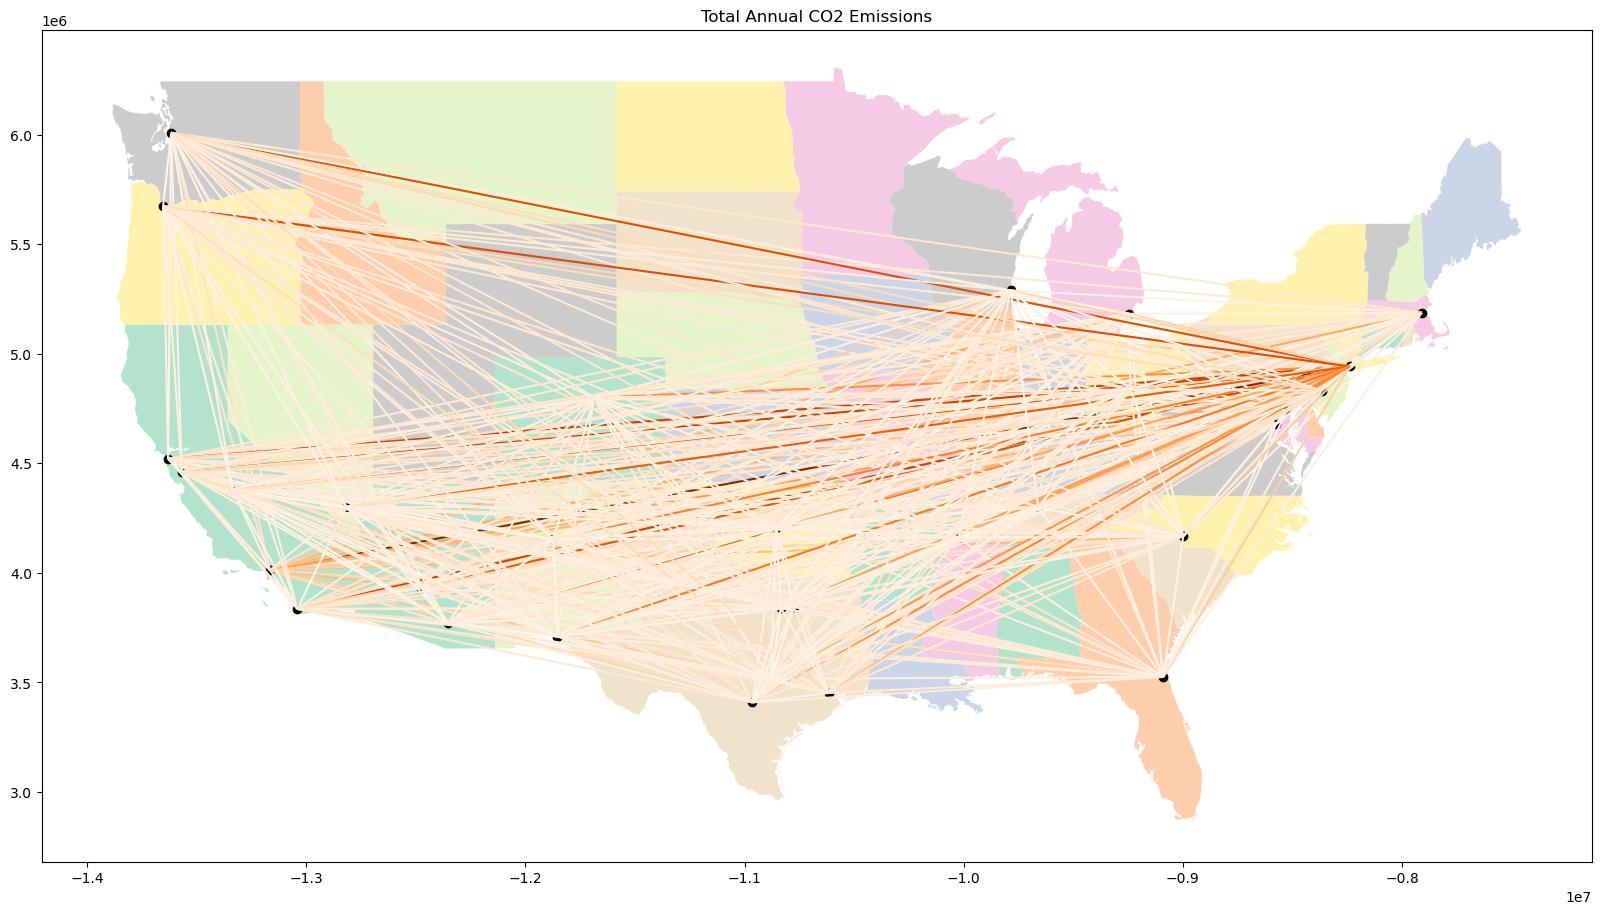

In [18]:
# create line segments for every pair of cities
line_segments = gpd.GeoDataFrame(
    big_cities_cross.reset_index()[['NAME_dep', 'NAME_arr', 'annual_passengers', 'annual_g_co2_flight']],
    geometry=[LineString(coords) for coords in zip(big_cities_cross['geometry_dep'], big_cities_cross['geometry_arr'])],
    crs=og_crs
)  # type: ignore

fig, ax1 = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(20, 20))

ax1 = states.plot(ax=ax1, cmap='Pastel2')
ax1 = cities_for_plot.plot(ax=ax1, marker='o', color='black')
ax1 = line_segments.to_crs(epsg=3395).plot(ax=ax1, column='annual_g_co2_flight', cmap='Oranges')  # type: ignore
ax1.set_title('Total Annual CO2 Emissions')

# ax2 = states.plot(ax=ax2, cmap='Pastel2')
# ax2 = cities_for_plot.plot(ax=ax2, marker='o', color='black')
# ax2 = line_segments.to_crs(epsg=3395).plot(ax=ax2, column='annual_passengers', cmap='Oranges').set_title('Total Annual Passenger Volume') #type: ignore

In [19]:
# todo kaggle dataset
# def makelines(pt1, pt2):
#     try:
#         return LineString([pt1, pt2])
#     except:
#         return None


# kaggle = pd.read_csv('./data/kaggle-usa-airport-dataset.csv')
# kaggle['Fly_date'] = pd.to_datetime(kaggle['Fly_date'])
# kaggle['org_pt'] = kaggle.apply(lambda row: Point(row['Org_airport_long'], row['Org_airport_lat']), axis='columns')
# kaggle['dest_pt'] = kaggle.apply(lambda row: Point(row['Dest_airport_long'], row['Dest_airport_lat']), axis='columns')
# kaggle = kaggle.drop(columns=['Org_airport_lat', 'Org_airport_long', 'Dest_airport_lat', 'Dest_airport_long'])
# kaggle['lines'] = kaggle.apply(
#     lambda row: makelines(row['org_pt'], row['dest_pt']),
#     axis='columns'
# )
# kaggle = kaggle.dropna()


In [20]:
db1b = pd.read_csv('./data/db1b-survey/market/Origin_and_Destination_Survey_DB1BMarket_2022_1.csv')
db1b

,ItinID,MktID,MktCoupons,Year,Quarter,OriginAirportID,OriginAirportSeqID,OriginCityMarketID,Origin,OriginCountry,...,BulkFare,Passengers,MktFare,MktDistance,MktDistanceGroup,MktMilesFlown,NonStopMiles,ItinGeoType,MktGeoType,Unnamed: 41
0,202322120891,20232212089101,1,2023,2,11697,1169706,32467,FLL,US,...,0.0,4.0,583.00,1127.0,3,1127.0,1127.0,2,2,NaN
1,202322120892,20232212089201,1,2023,2,11697,1169706,32467,FLL,US,...,0.0,4.0,598.00,1127.0,3,1127.0,1127.0,2,2,NaN
2,202322120893,20232212089301,1,2023,2,11697,1169706,32467,FLL,US,...,0.0,1.0,600.00,1127.0,3,1127.0,1127.0,2,2,NaN
3,202322120894,20232212089401,1,2023,2,11697,1169706,32467,FLL,US,...,0.0,2.0,601.00,1127.0,3,1127.0,1127.0,2,2,NaN
4,202322120895,20232212089501,1,2023,2,11697,1169706,32467,FLL,US,...,0.0,2.0,608.00,1127.0,3,1127.0,1127.0,2,2,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7616853,202325107441,20232510744101,2,2023,2,10599,1059904,30599,BHM,US,...,0.0,1.0,342.00,1787.0,4,1787.0,1768.0,2,2,NaN
7616854,202325107441,20232510744103,2,2023,2,13891,1389101,32575,ONT,US,...,0.0,1.0,364.00,1902.0,4,1902.0,1768.0,2,2,NaN
7616855,202325107442,20232510744201,2,2023,2,10599,1059904,30599,BHM,US,...,0.0,1.0,371.65,1787.0,4,1787.0,1768.0,2,2,NaN
7616856,202325107442,20232510744203,2,2023,2,13891,1389101,32575,ONT,US,...,0.0,1.0,473.35,2276.0,5,2276.0,1768.0,2,2,NaN


In [43]:
# db1b['Passengers'].sum()
# db1b.loc[(db1b['Origin'] == 'BOS') & (db1b['Dest'] == 'ROC')].iloc[0]

# ItinGeoType
# db1b.loc[db1b['ItinGeoType'] == 2]['Passengers'].sum() * 4 * 10
# 576,978,680.0

# db1b.loc[db1b['OpCarrier'] == 'B6']['Passengers'].sum() * 4 * 10
# 30,775,120.0

# db1b.loc[db1b['TkCarrier'] == 'B6']['Passengers'].sum() * 4 * 10
# 30,697,440.0

# db1b.loc[(db1b['Origin'] == 'BOS') & (db1b['Dest'] == 'JFK')]['Passengers'].sum() * 4 * 10
# 115,680.0

# db1b.loc[(db1b['OriginCityMarketID'] == 30721) & (db1b['DestCityMarketID'] == 31703)]['Passengers'].sum() * 10 * 4
# 30721 BOS
# 31703 NYC
# 767,800.0

# 767800 / (8.468e6 + 654776)
# about 0.08416297846181908 of combined pop

# db1b.loc[(db1b['OriginCityMarketID'] == 31703) | (db1b['DestCityMarketID'] == 31703)]['Passengers'].sum() * 10 * 4
# 81,752,760.0


81752760.0

In [45]:
db1b.iloc[0]

ItinID                  202322120891
MktID                 20232212089101
MktCoupons                         1
Year                            2023
Quarter                            2
OriginAirportID                11697
OriginAirportSeqID           1169706
OriginCityMarketID             32467
Origin                           FLL
OriginCountry                     US
OriginStateFips                   12
OriginState                       FL
OriginStateName              Florida
OriginWac                         33
DestAirportID                  11433
DestAirportSeqID             1143302
DestCityMarketID               31295
Dest                             DTW
DestCountry                       US
DestStateFips                     26
DestState                         MI
DestStateName               Michigan
DestWac                           43
AirportGroup                 FLL:DTW
WacGroup                       33:43
TkCarrierChange                  0.0
TkCarrierGroup                    DL
O

In [ ]:
# to eval direct connections vs indirect:
# part of value of state of rail network is the time taken to travel between two cities...
# ...calculate as: (sum of travel times of segments) + (sum of estimated transfer times)
